In [82]:
from pydantic import BaseModel
import pandas as pd 
import os
from dotenv import load_dotenv
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph,START,END
load_dotenv()
import os 
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
os.environ["GOOGLE_SERPER_API_KEY"] = os.getenv("SERPER_API_KEY")
from typing import Annotated, Literal, TypedDict

import bs4

from langchain import hub
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough,RunnableLambda
from langchain_google_genai import ChatGoogleGenerativeAI,GoogleGenerativeAIEmbeddings
from langchain_groq import ChatGroq
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain.utilities import GoogleSerperAPIWrapper
from langchain.load import dumps, loads
from langchain.prompts import PromptTemplate,ChatPromptTemplate
from langchain_google_genai import GoogleGenerativeAIEmbeddings,ChatGoogleGenerativeAI
embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
# llm = ChatGoogleGenerativeAI(
#     model="gemini-1.5-pro",

#     # other params...
# )
llm = ChatGroq(temperature=0, model_name="llama-3.3-70b-versatile")
from langgraph.graph.message import add_messages
from pydantic import BaseModel,Field
from langchain_core.tools import tool
from langgraph.graph import StateGraph,MessagesState,END
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults

In [83]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"greet the user first ", name="Model")]
# messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"Hello i want me to help your name is userinput bot yes?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

greet the user first
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

Hello i want me to help your name is userinput bot yes?


In [84]:
result=llm.invoke(messages)

In [85]:
result

AIMessage(content='Hello. I\'m an AI designed to assist and communicate with users, and I don\'t have a personal name, but I can go by "UserInput Bot" if you\'d like. You can think of me as your helpful companion for any questions or topics you\'d like to discuss. How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 75, 'total_tokens': 141, 'completion_time': 0.24, 'prompt_time': 0.010861724, 'queue_time': 0.026897661, 'total_time': 0.250861724}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4196e754db', 'finish_reason': 'stop', 'logprobs': None}, id='run-30cd88c5-075c-4ae5-b780-0c9ed383ba2c-0', usage_metadata={'input_tokens': 75, 'output_tokens': 66, 'total_tokens': 141})

In [86]:
result.usage_metadata

{'input_tokens': 75, 'output_tokens': 66, 'total_tokens': 141}

In [87]:
def multiply(a,b):
    """mu"""
    return a*b

In [88]:
llm_with_tools=llm.bind_tools([multiply])

In [89]:
tool_call=llm_with_tools.invoke([HumanMessage(content=f"what is 2 multiplied by 3",name="pujan")])

In [90]:
tool_call.additional_kwargs['tool_calls']

[{'id': 'call_ygtv',
  'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'},
  'type': 'function'}]

In [91]:
#using messages as state 

In [92]:
from typing import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

In [93]:
#the problem is we want to append messages to our messages state key 
# we use add _messages for that

In [94]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [95]:
#langchain has its own thing to appends

In [96]:
from langgraph.graph import MessagesState

class state(MessagesState):
    pass

In [97]:
initial_message =[
    AIMessage(content=f"greet the user first ", name="Model"),
    HumanMessage(content="I am lo")
]
new_message=AIMessage(content="sure we are")
add_messages(initial_message,new_message)

[AIMessage(content='greet the user first ', additional_kwargs={}, response_metadata={}, name='Model', id='616cd76a-0f49-41d6-b115-4a25b33ead1d'),
 HumanMessage(content='I am lo', additional_kwargs={}, response_metadata={}, id='43b70535-5795-4835-9ba2-fbcce088a274'),
 AIMessage(content='sure we are', additional_kwargs={}, response_metadata={}, id='3ea59090-8501-425d-9851-7e77486d69b9')]

In [98]:
class MessagesState(MessagesState):
    pass 

def tool_calling_llm(state:MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [99]:
builder=StateGraph(MessagesState)
builder.add_node("tool_call", tool_calling_llm)
builder.add_edge(START,"tool_call")
builder.add_edge("tool_call",END)
graph=builder.compile()

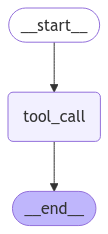

In [100]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [101]:
messages=graph.invoke({"messages":HumanMessage(content="Hello how are you!")})

In [102]:
messages

{'messages': [HumanMessage(content='Hello how are you!', additional_kwargs={}, response_metadata={}, id='76de12c7-0c97-40dd-83fe-bf8f0df6b262'),
  AIMessage(content="I'm doing well, thanks for asking. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 209, 'total_tokens': 234, 'completion_time': 0.090909091, 'prompt_time': 0.027454725, 'queue_time': 0.017024820000000003, 'total_time': 0.118363816}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'stop', 'logprobs': None}, id='run-007327b7-a23a-4506-9540-4543b84d58e0-0', usage_metadata={'input_tokens': 209, 'output_tokens': 25, 'total_tokens': 234})]}

In [103]:
messages=graph.invoke({"messages":HumanMessage(content="i want to multiply 2 and 3")})

In [104]:
messages

{'messages': [HumanMessage(content='i want to multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='ac5f83cf-9504-41a5-b28b-db3b44ed5c54'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ef0x', 'function': {'arguments': '{"a": 2, "b": 3}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 213, 'total_tokens': 232, 'completion_time': 0.069090909, 'prompt_time': 0.028878616, 'queue_time': 0.020179758000000002, 'total_time': 0.097969525}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-dd4dbeb4-8ad0-4c25-b663-27212afadd2c-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_ef0x', 'type': 'tool_call'}], usage_metadata={'input_tokens': 213, 'output_tokens': 19, 'total_tokens': 232})]}